

<img src="https://www.voiceprivacychallenge.org/img/vp-logo-192.png" alt="VPC" width=150>


# Welcome

```sh
2nd VoicePrivacy Challenge Workshop & ISCA SPSC Symposium.

Friday, September 23, 2022
11:40 - 12:00	Tutorial Part 2 
```

This is a hands-on tutorial on speaker anonymization, mainly using Voice Privacy Challenge 2022 baselines. **You will hear the anonymized audios**! 



Presenter: [Xin Wang](http://tonywangx.github.io/)


## Motivation

A tutorial notebook that is

* **easy to play with**
  * The official code integrates baseline systems, data processing pipelines from various tools, and many evaluation metrics. The learning curve is steep. 
  * This notebook is on **input speech $\rightarrow$ anonymized speech** (part of it)
  * Pure Python/Pytorch
  * Pre-trained models are used

* **NOT computational demanding**: a laptop without GPU is sufficient

Hope that you can have a better high-level understanding on the baseline. Also hope that you can better understand more advanced methods.



## Notes

If you want to execute the code on Google colab: 
* You need a Google accout (i.e., gmail account). 
* This notebook will run on a ''virtual machine'' for you. It will not affect other users :)
* More details on the usage of Google Colab can be found [here](https://research.google.com/colaboratory/).

Else:
* Just simply browse the notebook as if you are viewing a web page

⬅ Table of contents is on the left side.


We cannot cover all the details within 20 minutes, and we focus on 
**DNN-based baseline B1.b, speaker vector anonymization and synthesis part**

Codes are adopted from official github, but there are some differences:

1. Not PLDA-based distance but cosine-based distance;

2. Not speaker-level but utterance-level anonymization 

# Section 0. Preparation



## Install and download
This hands-on session is mainly using Python (Numpy & Scipy) and Pytorch.

Most of the requirements are provided by the Colab, but we need to install additional packages and download pre-trained models and data.

In [1]:
# To editors: you can add your own network storage 
!echo "Download external zip "
!wget --quiet --show-progress -O vpc2022-part1.zip https://www.dropbox.com/sh/k0chwkfroqoo92t/AACgcr5fUhagdIeo8VCG5pKNa
!echo "Unzip files"

# if you are on Google Colab
#!unzip -q -o vpc2022-part1.zip -x / -d /content
#!if [ -d "/content/data" ]; then echo "Done"; else echo "Please contact with the author"; fi

# if you are running notebook using your own jupyter server
#  change the path
!unzip -q -o vpc2022-part1.zip -x / -d ./
!if [ -d "./data" ]; then echo "Done"; else echo "Please contact with the author"; fi


Download external zip 
vpc2022-part1.zip   100%[===================>]  21.21M  15.5MB/s    in 1.4s    
Unzip files
Done


In [3]:
# for convenience, define a path to the folder on Google Colab runtime

# if you are on Google Colab
#g_workpath = '/content'

# if you are running notebook using your own jupyter server
g_workpath = './'

In [4]:
# Install kaldiio
!pip install kaldiio

# Install UMAP if you want to use it (hard to install dependency)
# !pip install umap-learn

## Load packages

In [69]:
# If you run the notebook on your own jupyter servers, 
# please install the following dependency in advance

# If you run it on Google Colab, they are already available

import os
import sys
import numpy as np
import random
import librosa

from os.path import join, isdir
from scipy.spatial import distance
import scipy.io.wavfile

import pandas as pd
from kaldiio import WriteHelper, ReadHelper
from sklearn.manifold import TSNE

# Not import here
#import umap

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=False)

## Helper functions

In [6]:
# define some common data IO functions

# Function below are for reading / writing binary data
# See more detailed tutorial in Chapter 1 here
# https://colab.research.google.com/drive/1EO-ggi1U9f2zXwTiqg7AEljVx11JKta7#scrollTo=EAJ_-GCO3YU0

def f_read_raw_mat(filename, col, data_format='f4', end='l'):
    """data = f_read_raw_mat(filename, col, data_format='float', end='l')
    Read the binary data from filename
    Return data, which is a (N, col) array

    input
    -----    
       filename: str, path to the binary data on the file system
       col:      int, number of column assumed by the data matrix
       format:   str, please use the Python protocal to write format
                 default: 'f4', float32
       end:      str, little endian 'l' or big endian 'b'?
                 default: 'l'
    output
    ------
       data: np.array, shape (N, col), where N is the number of rows
           decided by total_number_elements // col
    """
    f = open(filename,'rb')
    if end=='l':
        data_format = '<'+data_format
    elif end=='b':
        data_format = '>'+data_format
    else:
        data_format = '='+data_format
    datatype = np.dtype((data_format,(col,)))
    data = np.fromfile(f,dtype=datatype)
    f.close()
    if data.ndim == 2 and data.shape[1] == 1:
        return data[:,0]
    else:
        return data
    
  
def f_write_raw_mat(data, filename, data_format='f4', end='l'):
    """flag = write_raw_mat(data, filename, data_format='f4', end='l')
    Write data to file on the file system as binary data

    input
    -----
      data:     np.array, data to be saved
      filename: str, path of the file to save the data
      data_format:   str, data_format for numpy
                 default: 'f4', float32
      end: str   little endian 'l' or big endian 'b'?
                 default: 'l'

    output   
    ------
      flag: bool, whether the writing is done or not
    """
    if not isinstance(data, np.ndarray):
        print("Error write_raw_mat: input should be np.array")
        return False
    f = open(filename,'wb')
    if len(data_format)>0:
        if end=='l':
            data_format = '<'+data_format
        elif end=='b':
            data_format = '>'+data_format
        else:
            data_format = '='+data_format
        datatype = np.dtype(data_format)
        temp_data = data.astype(datatype)
    else:
        temp_data = data
    temp_data.tofile(f,'')
    f.close()
    return True

# Function to load waveform data
def waveReadAsFloat(wavFileIn):
    """ sr, wavData = wavReadToFloat(wavFileIn)                       
    Wrapper over scipy.io.wavfile                                     
    Return:                                                           
        sr: sampling_rate                                             
        wavData: waveform in np.float32 (-1, 1)                       
    """

    sr, wavdata = scipy.io.wavfile.read(wavFileIn)

    if wavdata.dtype is np.dtype(np.int16):
        wavdata = np.array(wavdata, dtype=np.float32) / \
                  np.power(2.0, 16-1)
    elif wavdata.dtype is np.dtype(np.int32):
        wavdata = np.array(wavdata, dtype=np.float32) / \
                  np.power(2.0, 32-1)
    elif wavdata.dtype is np.dtype(np.float32):
        pass
    else:
        print("Unknown waveform format %s" % (wavFileIn))
        sys.exit(1)
    return sr, wavdata

In [7]:
# Here we define some functions to load and write data.
# These functions are from official repository.  Some are simplified for explanation purpose.

def load_xvector_scp(xvec_file):
    """xvector_dic = load_xvector_scp(xvec_file)
    :input: xvec_file, string, path to the speaker xvector scp file
    :output: xvector_dic, dic, where xvector_dic[speaker_ID] -> x-vector
    """
    xvector_dic = {}
    counter = 0 
    with ReadHelper('scp:'+xvec_file) as reader:
        for key, xvec in reader:                                                              
            xvector_dic[key] = xvec
            counter += 1
    print("Read ", counter, "pool xvectors")
    return xvector_dic

def load_spk_gender(gender_map_file):   
    """gender_map = load_spk_gender(gender_map_file)
    :input: gender_map_file, string, path to the speaker gender file
    :output: gender_map, dic, where gender_map[speaker_ID] -> gender 
    """
    with open(gender_map_file, 'r') as file_ptr:
        gender_map = {x.split()[0]:x.rstrip('\n').split()[1] for x in file_ptr}
    return gender_map

def concat_input(input_ppg, input_f0, input_xvec):
    """ input_buf = concat_input(input_ppg, input_f0, input_xvec)
    This function simply concatenate PPG, F0, and xvector as input for block 5

    :input: input_ppg, torch.tensor, PPG tensor, in shape (N, L), where
            N is the number of frames, L is the number of dimensions of PPG
    :input: input_f0, torch.tensor, F0 tensor, in shape (N, ) or (N, 1)
    :input: input_xvec, torch.tensor, xvector, in shape (M) or (1, M), where
            M is the number of dimensions of xvector
    :output: input_buf, torch.tensor, in shape (N, L+M+1)
    """    
    # input length
    input_len = min([input_ppg.shape[0], input_f0.shape[0]])
    
    # expand dimension of F0 tensor
    if input_f0.ndim == 1:
        input_f0_ = np.expand_dims(input_f0, axis=1)
    else:
        input_f0_ = input_f0
        
    # repeat xvector to each frame
    input_vec_ = np.tile(input_xvec, (input_len, 1))
    
    # concatenate
    input_buf = np.concatenate(
        [input_ppg[0:input_len], input_vec_[0:input_len], input_f0_[0:input_len]], 
        axis=1)
    
    return input_buf


# Section 1. DNN-based approach - Baseline B1.b

<img src="https://www.researchgate.net/publication/359435670/figure/fig4/AS:1137062136823811@1648108147381/Second-baseline-anonymization-system-B1b.png" alt="B1.b" width=400>

* Feature extraction (blocks 1, 2, and 3)
* Speaker vector anonymization (block 4)
* Waveform synthesizer (block 5)

BN features and F0 will not be altered$^1$. The speaker vector is anonymized. 

This tutorial only does **speaker vector anonymization (block 4)** and **waveform synthesis (block 5)**. 

Feature extractors will be skippped. We will load prepared F0, BN feature, and x-vector.




FOOTNOTE:
* 1 For those who are not familiar, this is required by the [evaluation plan](https://www.voiceprivacychallenge.org/vp2020/docs/VoicePrivacy_2022_Eval_Plan_v1.0.pdf). the system is required to
  * output a speech waveform
  * conceal the speaker identity
  * leave the linguistic content and paralinguistic attributes unchanged
  * ensure that all trial utterances from a given speaker are uttered by the same pseudo-speaker, while trial utterances from different speakers are uttered by different pseudo-speakers.

## Sec.1.1 Tools for speaker vector anonymization


Given an input speaker vector $\boldsymbol{x}\in\mathbb{R}^D$, compute a pseudo speaker vector
$\boldsymbol{y}\in\mathbb{R}^D$. 


$\boldsymbol{x}\xrightarrow{\text{anonymize}} \boldsymbol{y}$


Suppose there is a pool of speaker vectors (marked by `o`) in the speaker space. 

B1.b computes the anonymized $\boldsymbol{y}$ by
1. selecting `K` **farthest** speaker vectors;
2. randomly choosing `K*` out of the `K` vectors;
3. taking the average of the `K*` vectors as `y`

```sh
         /-----------
         | o  'o'    o |---
       o |--     y 'o'  o o |
   o o   o  \  o  'o' o     | K farthest vectors
    o        ------    o   /  K* randomly selected vectors 'o'
 o  o        o  o  \------/   Average of 'o' becomes y
   o      o      o
   o   x     o      o  o    
    o     o o    o 

```

We need 
1. a function to measure the closeness or similarity between two vectors
2. functions to select the farthest vectors, random sampling, and average



### Similarity between two vectors

Many ways can be used. 

Baseline B1.b uses a PLDA-based distance measure. 

For demonstration, we use cosine similarity. 

Given $\boldsymbol{x}\in\mathbb{R}^D$ and $\boldsymbol{o}\in\mathbb{R}^D$, their cosine similarity is $\frac{\boldsymbol{x}^\top\boldsymbol{o}}{||\boldsymbol{x}||_2 ||\boldsymbol{o}||_2}$


In practice, we can do
1. first, L2 normalization $\tilde{{x}} = \frac{{x}}{||{x}||_2}$, $\tilde{{o}} = \frac{{o}}{||{o}||_2}$
2. then, dot-product $\tilde{{x}}^\top\tilde{{o}}$


In [28]:
# Official code uses scipy.spatial.distance.cosine 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html#scipy.spatial.distance.cosine
# https://github.com/Voice-Privacy-Challenge/Voice-Privacy-Challenge-2022/blob/master/baseline/local/anon/compute_spk_pool_cosine.py
# 
# Here we use naive implementation to show what is going on
def l2_norm(x):
    """ output = l2_norm(x)
    Length normalization, can process multiple input vectors at the same time
    :input: vec, np.array, (B, D)
    :output: same shape as input
    """
    norm = np.linalg.norm(x, axis=-1)
    return x / np.expand_dims(norm, axis=-1)
    
def cos_similarity(vecs1, vecs2):
    """ sim_mat = cos_similarity(vecs1, vecs2)
    Measure cosine similarity between each pair of vectors from vecs1 and vecs2
    
    :input: vecs1, np.array, (N, D)
        where N is the number of the vectors in group1, 
        D is the number of dimensions of each vector
    :input: vecs2, np.array, (M, D)
        where M is the number of the vectors in group2,
    :output: sim_mat, np.array, (N, M)
        where sim_mat[i, j] is the similarity between vecs1[i] and vecs2[j]
    
    If vecs1 or vecs2 contains only one vector and is in shape (D, ), it will be
    converted to (1, D) internally.
    """
    def _wrap_array(x):
        """ o = wrap_array(x)
        To make the shapre of x be (1, D)
        """
        if x.ndim == 1:
            return np.expand_dims(x, axis=0)
        elif x.ndim > 2:
            print("Unable to process tensor input in cos_similarity")
        else:
            return x
    
    # L2 normalization
    tmp_vecs1 = l2_norm(_wrap_array(vecs1))
    tmp_vecs2 = l2_norm(_wrap_array(vecs2))

    # compute inner-product
    sim_mat = np.matmul(tmp_vecs1, tmp_vecs2.T)
    return sim_mat

In [29]:
# This is for sanity check, you can compare the output from cos_similarity with 
# that from scipy.spatial.distance
# We will skip this

data1 = np.random.randn(10)
data2 = np.random.randn(10)

from scipy.spatial import distance
d1 = 1 - distance.cosine(data1, data2)
d2 = cos_similarity(data1, data2)

print(d1)
print(d2)

-0.18632666201453096
[[-0.18632666]]


#### a detailed example

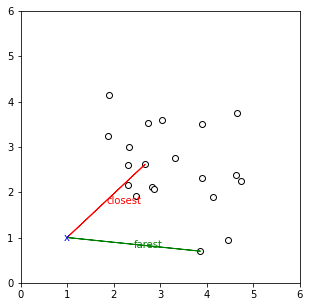

In [30]:
# A more complicated example

# produce a set of N 2D random vectors
Total_num = 20
dim = 2
np.random.seed(1)
pool = np.random.randn(Total_num, dim) + 3.0

# an input vector x, let us set it to (1, 1)
x = np.ones([1, 2])

# compute cos similarity
sim_mat = cos_similarity(x, pool)

# find the cloest and farest
idx_closest = np.argsort(sim_mat[0])[-1]
idx_farthest = np.argsort(sim_mat[0])[0]

#===
# plot figure
#===
plot_lim = (0.0, 6.0)
fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(111)

# pool
axis.scatter(pool[:, 0], pool[:, 1], marker='o', edgecolors='k', color='w')
axis.set_ylim(plot_lim)
axis.set_xlim(plot_lim)

# input x
axis.text(x[0, 0], x[0, 1], 'x', color='b', va='center', ha='center')

# closest x
axis.arrow(x[0, 0], x[0, 1], pool[idx_closest, 0] - x[0, 0], pool[idx_closest, 1] - x[0, 1], 
           overhang = 0.1, color='r')
axis.text((pool[idx_closest, 0] + x[0, 0])/2, (pool[idx_closest, 1] + x[0, 1])/2, 
          'closest', color='r', va='center', ha='left');
# fareset x
axis.arrow(x[0, 0], x[0, 1], pool[idx_farthest, 0] - x[0, 0], pool[idx_farthest, 1] - x[0, 1], 
           overhang = 0.1, color='g')
axis.text((pool[idx_farthest, 0] + x[0, 0])/2, (pool[idx_farthest, 1] + x[0, 1])/2, 
          'farest', color='g', va='center', ha='left');

You may wonder why the `cloest` and `farthest` dots are not the cloest and farthest in the 2D space.

The reason is that we are using cosine similarity which measures the angle between two vectors.

To show it, we can change the way to plot the figure



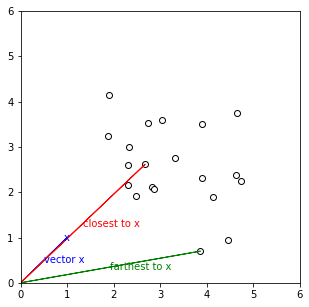

In [31]:
#===
# plot figure
#===
fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(111)

# pool
axis.scatter(pool[:, 0], pool[:, 1], marker='o', edgecolors='k', color='w')
axis.set_ylim(plot_lim); axis.set_xlim(plot_lim);

# input x
axis.text(x[0, 0], x[0, 1], 'x', color='b', va='center', ha='center')


axis.arrow(0, 0, x[0, 0], x[0, 1],  overhang = 0.1, color='b')
axis.text(x[0, 0]/2, x[0, 1]/2,  'vector x', color='b', va='center', ha='left');

axis.arrow(0, 0, pool[idx_closest, 0], pool[idx_closest, 1],  overhang = 0.1, color='r')
axis.text(pool[idx_closest, 0]/2, pool[idx_closest, 1]/2,  
          'closest to x', color='r', va='center', ha='left');

axis.arrow(0, 0, pool[idx_farthest, 0], pool[idx_farthest, 1],  overhang = 0.1, color='g')
axis.text(pool[idx_farthest, 0]/2, pool[idx_farthest, 1]/2,  
          'farthest to x', color='g', va='center', ha='left');

We can see how the angle between <font color='blue'>blue vector</font> and <font color='red'>red vector</font> is the smallest, while <font color='blue'>blue vector</font> and <font color='green'>green vector</font> is the largest.


Another way to visualize it is to plot the L2 normalized vectors -- we are measuring the cos similarity on L2 normalized vectors.


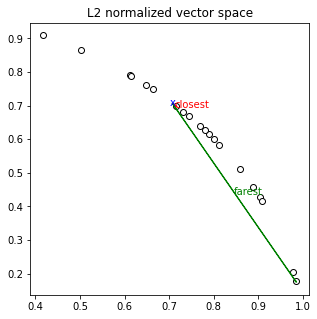

In [32]:
x_normed = l2_norm(x)
pool_normed = l2_norm(pool)


#===
# plot figure
#===
fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(111)

# pool
axis.scatter(pool_normed[:, 0], pool_normed[:, 1], marker='o', edgecolors='k', color='w')

# input x
axis.text(x_normed[0, 0], x_normed[0, 1], 'x', color='b', va='center', ha='center')

# closest x
axis.arrow(x_normed[0, 0], x_normed[0, 1], 
           pool_normed[idx_closest, 0] - x_normed[0, 0], 
           pool_normed[idx_closest, 1] - x_normed[0, 1], 
           overhang = 0.1, color='r')
axis.text((pool_normed[idx_closest, 0] + x_normed[0, 0])/2, 
          (pool_normed[idx_closest, 1] + x_normed[0, 1])/2, 
          'closest', color='r', va='center', ha='left');
# fareset x
axis.arrow(x_normed[0, 0], x_normed[0, 1], 
           pool_normed[idx_farthest, 0] - x_normed[0, 0], 
           pool_normed[idx_farthest, 1] - x_normed[0, 1], 
           overhang = 0.1, color='g')
axis.text((pool_normed[idx_farthest, 0] + x_normed[0, 0])/2, 
          (pool_normed[idx_farthest, 1] + x_normed[0, 1])/2, 
          'farest', color='g', va='center', ha='left');
axis.set_title('L2 normalized vector space');

In this space, we see that the `closest` and `farthest` dots are indeed closest to and farthest from x. 

This is expected because Euclien distance in the normalized vector space is linked to cos similarity by

$\begin{align}
|| \tilde{x} - \tilde{o}||_2 &= (\tilde{x} - \tilde{o})^\top(\tilde{x} - \tilde{o}) \\ 
&= \tilde{x}^\top\tilde{x} + \tilde{o}^\top\tilde{o} - 2\tilde{x}^\top\tilde{o} \\ 
&= 2(1-\tilde{x}^\top\tilde{o}) \qquad\qquad \text{# note that }\tilde{x}^\top\tilde{x}=1, \tilde{o}^\top\tilde{o}=1\\
&= 2(1-\text{cos_sim}(\tilde{x}, \tilde{o}))
\end{align}$




### Retrieve the K farthest vectors 

Given the distance measure, it is straightward to 
* retrieve the farthest $K$ vectors, 
* randomly sample $K^*$ vectors.



In [33]:
# Simple example for 2D vectors

# K
K = 5

# K* 
K_star = 3

# prepare toy data
# produce a set of N 2D random vectors
Total_num = 20
dim = 2
np.random.seed(1)
pool = np.random.randn(Total_num, dim) + 3.0

# an input vector x, let us set it to (1, 2)
x = np.ones([1, 2])



Text(3.7021001746828444, 2.4411253664822854, 'y')

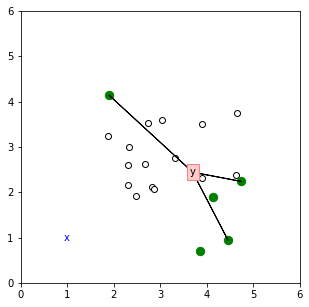

In [34]:
# compute cos similarity
sim_mat = cos_similarity(x, pool)


# find the cloest and farest
ids_farthest = np.argsort(sim_mat[0])[:5]

# randomly get the K_star vectors
np.random.shuffle(ids_farthest)
selected_ids = ids_farthest[:K_star]

# average
ave_vec = np.mean(pool[selected_ids], axis=0, keepdims=True)

#===
# plot figure
#===
fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(111)
plot_lim = (0.0, 6.0)

# pool
axis.scatter(pool[:, 0], pool[:, 1], marker='o', edgecolors='k', color='w')
axis.set_ylim(plot_lim)
axis.set_xlim(plot_lim)

axis.text(x[0, 0], x[0, 1], 'x', color='b', va='center', ha='center')
axis.scatter(pool[ids_farthest, 0], pool[ids_farthest, 1], s = 70, color='g')

for idx in selected_ids:
  axis.arrow(ave_vec[0, 0], ave_vec[0, 1], 
             pool[idx, 0] - ave_vec[0, 0], pool[idx, 1] - ave_vec[0, 1])
axis.text(ave_vec[0, 0], ave_vec[0, 1], 'y', color='k', va='center', ha='center', 
           bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8)))

$K=5$ <font color=green>farthest vectors</font>

$K^*=3$ vectors randomly selected  from the farthest ones.


`y` is the averaged vector.

### Wrap up in functions

Now, we can encapsulate the above ideas into functions.

This is based on [official git repo](https://github.com/Voice-Privacy-Challenge/Voice-Privacy-Challenge-2022/blob/master/baseline/local/anon/gen_pseudo_xvecs.py)


Recap the differences from the official code:
  * cosine similarity, not PLDA-based distance
  * utterance-level anonymization



In [35]:
# get_top_K computes the K farthest vectors
# select_random_xvec get K* vectors
# K -> WORLD_SIZE
# K* -> REGION

def get_top_K(input_vec, input_gender, speaker_pool, speaker_gender_map, 
              WORLD_SIZE=200,
              sim_func = cos_similarity,
              flag_proximity = 'farthest', 
              flag_cross_gender = False):
    """ vec_buffer, speaker_list = get_top_K(input_vec, input_gender, 
           speaker_pool, speaker_gender_map, 
           WORLD_SIZE=200, 
           sim_func = cos_similarity, 
           flag_proximity = 'farthest', 
           flag_cross_gender = False)
    
    :input: input_vec, np.array, (N, D)
            we can simultaneously compute K vectors for each of the input vector,
            (for fast processing)
    :input: input_gender, str, 'm', 'f' or None, gender of the input vector
    :input: speaker_pool, dict, {speaker_id : speaker_vector}
    :input: speaker_gender_map, dict, {speaker_id : speaker_gender}
    :input: WORLD_SIZE, int, the K
    :input: sim_func, func, similarity function, by default, cos_similarity
    :input: flag_proximity, str, 'farthest' or 'nearest'
            by default 'farthest', 
    :input: flag_cross_gender, bool, whether to choose speaker of a different 
            gender from the input_vec
    
    :output: vec_buffer, np.array, (N, K, D)
             where vec_buffer[i] is the top_K vectors for the i-th input vector
    :output: speaker_list, list of list of str, 
             where speaker_list[i] is the top_K vector ID for the i-th input vec
    """
    
    # pre-select the speaker vectors based on gender    
    pool_vec_buf = []
    pool_vec_speaker = []
    for speaker in speaker_pool.keys():
        if input_gender is not None:
            if flag_cross_gender:
                if speaker_gender_map[speaker] == input_gender:
                    continue
            else:
                if speaker_gender_map[speaker] != input_gender:
                    continue
        pool_vec_buf.append(speaker_pool[speaker])
        pool_vec_speaker.append(speaker)
        
    # create a matrix format of the vectors
    pool_vec_buf = np.concatenate(pool_vec_buf, axis=0)
    
    # comptue similarity
    sim_mat = sim_func(input_vec, pool_vec_buf)
    
    # rank and get the world pool
    top_K_buffer = []
    speaker_list = []
    for input_idx in range(input_vec.shape[0]):
        
        if flag_proximity == 'farthest':
            sorted_idx = np.argsort(sim_mat[input_idx])
            
        elif flag_proximity == 'nearest':
            sorted_idx = np.argsort(sim_mat[input_idx])[::-1]
            
        else:
            print("Not implemented flag_proximity = {:s}".format(flag_proximity))
            sys.exit(1)
            
        # get the WORLD_SIZE
        sorted_key = sorted_idx[:WORLD_SIZE]
       
        # save the vector
        top_K_buffer.append(pool_vec_buf[sorted_key])
     
        # save the index of the vector
        speaker_list.append([pool_vec_speaker[x] for x in sorted_key])
            
    # to (input_size, WORLD_SIZE, dim)
    return np.stack(top_K_buffer, axis=0), speaker_list


def select_random_xvec(world_pool, world_speaker_id, region_size=100):
    """ vec_mat, idx = select_random_xvec(world_pool, world_speaker_id, region_size=100)
    
    Select the K* vectors. This function is designed to process the selection
    for N groups of K vectors. 
    
    :input: world_pool, np.array, (N, K, D), output given by get_top_K
    :input: world_speaker_id, list of list of str, speaker IDs in the pool
    :input: region_size, int, K*

    :output: vec_mat, np.array, (N, D)
             where vec_mat[i] is the anonymized vector for the i-th input 
    :output: idx, list of list of str, idx[i] is the selected K* speaker IDs for
             the i-th input group.
    """
    def _pseudo_xvec(candidate_pool, world_speaker_id, region_size):
        """
        """
        world_size, vec_dim = candidate_pool.shape
        # select region_size from world_pool
        random_idx = np.array(random.sample(range(world_size), region_size))
        # do average
        pseudo_xvec = np.mean(candidate_pool[random_idx], axis=0)
        return pseudo_xvec, np.array([world_speaker_id[x] for x in random_idx])

    if world_pool.ndim == 2:
        # input is a world pool for a single speaker, make it in shape
        # (1, K, D)
        world_pool = np.expand_dims(world_pool, axis=0)
        return _pseudo_xvec(world_pool, region_size)
    
    pseudo_xvec_list = []
    pseudo_spk_ids = []
    for tmp_pool, tmp_spks in zip(world_pool, world_speaker_id):
        y, z = _pseudo_xvec(tmp_pool, tmp_spks, region_size)
        pseudo_xvec_list.append(y)
        pseudo_spk_ids.append(z)

    return np.stack(pseudo_xvec_list, axis=0), np.array(pseudo_spk_ids)
        
        
def spk_anonymize(input_vec, 
                  input_gender, 
                  speaker_pool, 
                  speaker_gender_map, 
                  WORLD_SIZE=200, 
                  REGION_SIZE=100,
                  sim_func = cos_similarity,
                  flag_proximity = 'farthest', 
                  flag_cross_gender = False):
    """ vec_buffer, speaker_list = spk_anonymize(input_vec, input_gender, 
           speaker_pool, speaker_gender_map, 
           WORLD_SIZE=200, 
           REGION_SIZE=100,
           sim_func = cos_similarity, 
           flag_proximity = 'farthest', 
           flag_cross_gender = False)
    
    Just wrap up

    :input: input_vec, np.array, (N, D)
            we can simultaneously compute K vectors for each of the input vector,
            (for fast processing)
    :input: input_gender, str, 'm', 'f' or None, gender of the input vector
    :input: speaker_pool, dict, {speaker_id : speaker_vector}
    :input: speaker_gender_map, dict, {speaker_id : speaker_gender}
    :input: WORLD_SIZE, int, the K
    :input: sim_func, func, similarity function, by default, cos_similarity
    :input: flag_proximity, str, 'farthest' or 'nearest'
            by default 'farthest', 
    :input: flag_cross_gender, bool, whether to choose speaker of a different 
            gender from the input_vec
    
    :output: vec_buffer, np.array, (N, D)
             where vec_buffer[i] is the anonymized vector for the i-th input vector
    :output: speaker_list, list of list of str, 
             where speaker_list[i] are pool vector IDs used by the i-th input vec
    """

    # select the top_tool
    world_xvec, speaker_list = get_top_K(
        input_vec, input_gender, speaker_pool, gender_map, 
        WORLD_SIZE, sim_func,
        flag_proximity, flag_cross_gender)
    
    # get average over the randomly selected ones
    pseudo_xvec, used_speaker_list = select_random_xvec(
        world_xvec, speaker_list, region_size = REGION_SIZE)
    
    return pseudo_xvec, used_speaker_list


#### a detailed example 



In [36]:
# These are produced by the official baseline code (using sidekit x-vector)

# load gender map
gender_map = load_spk_gender(g_workpath + '/data/libritts_train_other_500/spk2gender')

# load the speaker pool
pool_xvector = load_xvector_scp(g_workpath + '/data/xvectors_libritts_train_other_500/spk_xvector.scp')

# speakers
pool_spk = list(pool_xvector.keys())

# convert it to matrix format
pool_xvector_mat = np.concatenate([pool_xvector[x] for x in pool_spk], axis=0)

Read  1160 pool xvectors


In [37]:
# the dictionary format
print("\nThe vector pool in dictionary format: ")
print("speaker IDs: {:s} ...".format(str(list(pool_xvector.keys())[0:10])))

# the np.array format
print("Each vector has {:d} dimensions".format(pool_xvector[list(pool_xvector.keys())[0]].shape[1]))




The vector pool in dictionary format: 
speaker IDs: ['1006', '102', '104', '1049', '1051', '1065', '107', '1084', '1085', '1092'] ...
Each vector has 256 dimensions


In [38]:
# set the parameter for demonstration

# K
WORLD_SIZE = 20

# K*
REGION_SIZE = 10

# for demonstration, let's use the first speaker in the pool as the input vector
# make it shape (1, D)
input_xvectors = np.array([pool_xvector['1006'][0]])
gender = gender_map['1006']


# anonymization
pseudo_xvec, used_speaker_list = spk_anonymize(input_xvectors, gender, pool_xvector, gender_map, WORLD_SIZE, REGION_SIZE)

# pseudo_xvec[0] is the anonymized xvector for input_xvectors[0]
# used_speaker_list[0] is the list of the K* pool speakers ID 


In [39]:
# the np.array format
print("The anoymized vector for 1006: {:s}".format(
    ' '.join(['{:.2f}'.format(x) for x in pseudo_xvec[0, 0:10]]) +  ' ...'));

# 
print("It is averaged from {:s}".format(', '.join(['pool_vector[{:s}]'.format(x) for x in used_speaker_list[0]])))

The anoymized vector for 1006: 0.02 -0.01 0.01 -0.03 -0.04 0.01 -0.03 0.01 -0.02 0.06 ...
It is averaged from pool_vector[5665], pool_vector[5949], pool_vector[7737], pool_vector[7265], pool_vector[5439], pool_vector[6153], pool_vector[2553], pool_vector[2050], pool_vector[1901], pool_vector[1154]


We can visualize the xvectors and pool.


In [40]:
# Let's visualize the xvectors

# create a matrix to contain the pool, the input, and the anonymized
tmp_mat = np.concatenate([pool_xvector_mat, input_xvectors, pseudo_xvec], axis=0)

# embedding into 2D space
#reducer = umap.UMAP()
#xvec_2d = reducer.fit_transform(tmp_mat)

# (tNSE) embedding into 2D space
xvec_2d = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=90).fit_transform(tmp_mat)

Text(0.5, 1.0, 'Anonymization using \n K=20 and K*=10')

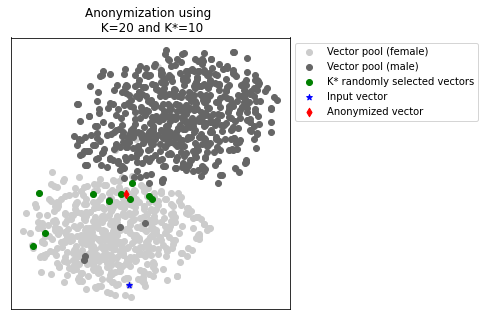

In [41]:
import matplotlib 
import matplotlib.pyplot as plt

check_idx = 0

# size of the pool
pool_size = len(pool_xvector)
# how many input vectors we want to anonymize, in this case 1
batch_size = input_xvectors.shape[0]

# get the row index of the K* vectors
used_xvec_idx = [pool_spk.index(x) for x in used_speaker_list[check_idx]]

# get the 

# index of the input xvector in the concatenated matrix
get_orig_xvec_idx = lambda x: pool_size + x
# index of the anonymized xvector in the concatenated matrix
get_pseudo_xvec_idx = lambda x: pool_size + batch_size + x 


fig = plt.figure(figsize=(5, 5))
axis = fig.add_subplot(111)

# female group in the pool
female_index = [pool_spk.index(x) for x in pool_xvector.keys() if gender_map[x] == 'f']
male_index = [pool_spk.index(x) for x in pool_xvector.keys() if gender_map[x] == 'm']

axis.scatter(xvec_2d[female_index, 0], xvec_2d[female_index, 1], alpha = 1.0, color=(0.8,0.8,0.8))
axis.scatter(xvec_2d[male_index, 0], xvec_2d[male_index, 1], alpha = 1.0, color=(0.4,0.4,0.4))

axis.scatter(xvec_2d[used_xvec_idx, 0],
             xvec_2d[used_xvec_idx, 1], color='g', alpha=1.0)

axis.scatter(xvec_2d[get_orig_xvec_idx(check_idx), 0],
             xvec_2d[get_orig_xvec_idx(check_idx), 1], color='b', marker='*')
axis.scatter(xvec_2d[get_pseudo_xvec_idx(check_idx), 0], 
             xvec_2d[get_pseudo_xvec_idx(check_idx), 1], color='r', marker='d')
axis.set_yticks([]);
axis.set_xticks([]);
axis.legend(['Vector pool (female)', 'Vector pool (male)', 'K* randomly selected vectors', 'Input vector', 'Anonymized vector'],
            bbox_to_anchor=[1.0, 1.0])

axis.set_title("Anonymization using \n K={:d} and K*={:d}".format(WORLD_SIZE, REGION_SIZE))

We can see the two clusters of vectors -- female and male speakers in the pool.

We selected the $K*$ vectors from the same gender group. 

## Sec.1.2 Anonymize a waveform


<img src="https://www.researchgate.net/publication/359435670/figure/fig4/AS:1137062136823811@1648108147381/Second-baseline-anonymization-system-B1b.png" alt="B1.b" width=500>

We will:
1. load prepared F0, BN-features, and original x-vectors,

2. get the anonymized xvector,

3. synthesize the anonymized waveform using original F0,  original BN features, and anonymized x-vector.

Feature extractors are currently not included in this notebook. 

In [42]:
# You can use the following provided waveforms as input
!ls ./data/input_trial/*.wav

./data/input_trial/1272-128104-0000.wav
./data/input_trial/1462-170142-0031.wav
./data/input_trial/1919-142785-0032.wav
./data/input_trial/1988-24833-0000.wav
./data/input_trial/2035-147961-0009.wav
./data/input_trial/2086-149220-0017.wav
./data/input_trial/2428-83705-0026.wav
./data/input_trial/2803-154328-0015.wav
./data/input_trial/3081-166546-0046.wav
./data/input_trial/3536-8226-0000.wav
./data/input_trial/3536-8226-0001.wav
./data/input_trial/3752-4944-0000.wav
./data/input_trial/8297-275156-0002.wav
./data/input_trial/8842-304647-0006.wav


In [43]:
# Please specify the trial name here
trial_name = '3536-8226-0001'

# if you know its gender, please specify either 'f' or 'm', otherwise None
input_gender = 'f'

In [44]:
# ===
# Configuration
# ===

# prepare file paths
input_data_dir = g_workpath + '/data/input_trial'
input_wav_f = os.path.join(input_data_dir, trial_name) + '.wav'
input_f0_f = os.path.join(input_data_dir, trial_name) + '.f0'
input_ppg_f = os.path.join(input_data_dir, trial_name) + '.ppg'
input_xvec_f = os.path.join(input_data_dir, trial_name) + '.xvector'

# feature dimensions are fixed
input_f0_dim = 1
input_ppg_dim = 256
input_xvec_dim = 256

# sampling rate
wav_sampling_rate = 16000

# acoustic feature upsampling rate, 
# this is equal to wav_sampling_rate * frame_shift for feature extraction 
feat_upsampling_rate = 160

# pretrained NSF waveform generation model
pretrained_model = os.path.join(g_workpath + '/models/B1b_sidekit/hifigan_nsf_trained_network.pt')

# in this notebook, we will use cpu to synthesize the waveform
device_name = 'cpu'

###
# Configuration for speaker vector anonymization
### 
# K
WORLD_SIZE = 200
# K*
REGION_SIZE = 100
flag_proximity ='farthest'

### Load features

In [45]:
# Load original waveform (for reference)
_, input_wav = waveReadAsFloat(input_wav_f)

# load pre-extracted features
input_ppg = f_read_raw_mat(input_ppg_f, input_ppg_dim)
input_xvec = f_read_raw_mat(input_xvec_f, input_xvec_dim)[0]
input_f0 = f_read_raw_mat(input_f0_f, input_f0_dim)

# in the future, we will integrate the feature extractors

### Speaker vector anonymization

We will use the functions defined above to anonymize the x-vector.


**Load pool**

In [46]:
# These are produced by the official baseline code (using sidekit x-vector)

# load gender map
gender_map = load_spk_gender(g_workpath + '/data/libritts_train_other_500/spk2gender')

# load pool 
pool_xvector = load_xvector_scp(g_workpath + '/data/xvectors_libritts_train_other_500/spk_xvector.scp')

# speakers
pool_spk = list(pool_xvector.keys())

# convert it to matrix format (for visualization)
pool_xvector_mat = np.concatenate([pool_xvector[x] for x in pool_spk], axis=0)

# print some informaiton
print("\nThe vector pool in dictionary format: ")
print("speaker IDs: {:s} ...".format(str(list(pool_xvector.keys())[0:10])))
print("Each vector has {:d} dimensions".format(pool_xvector[list(pool_xvector.keys())[0]].shape[1]))

Read  1160 pool xvectors

The vector pool in dictionary format: 
speaker IDs: ['1006', '102', '104', '1049', '1051', '1065', '107', '1084', '1085', '1092'] ...
Each vector has 256 dimensions


**X-vector anonymization**

In [47]:
# wrap it to [1, D] format
input_xvectors = np.array([input_xvec])

# get the anonymized vector
print("Anonymizing input xvector using \n K={:d}\nK*={:d}".format(
    WORLD_SIZE, REGION_SIZE))
# 
pseudo_xvec, used_speaker_list = spk_anonymize(
    input_xvectors, input_gender, pool_xvector, gender_map, 
    WORLD_SIZE, REGION_SIZE, flag_proximity = flag_proximity)

Anonymizing input xvector using 
 K=200
K*=100


**Visualization**

In [48]:
# Visualization

# create a matrix to contain the pool, the input, and the anonymized
tmp_mat = np.concatenate([pool_xvector_mat, input_xvectors, pseudo_xvec], axis=0)

# embedding into 2D space
#reducer = umap.UMAP()
#xvec_2d = reducer.fit_transform(tmp_mat)

xvec_2d = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=90).fit_transform(tmp_mat)


Text(0.5, 1.0, 'Anonymization using \n K=200 and K*=100')

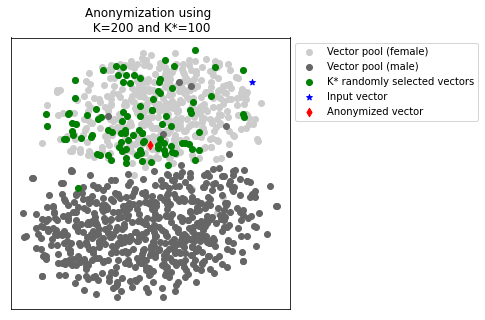

In [49]:
import matplotlib 
import matplotlib.pyplot as plt

check_idx = 0

# size of the pool
pool_size = len(pool_xvector)

# how many input vectors we anonymized? in this case 1
batch_size = input_xvectors.shape[0]

# get the row index of the K* vectors
used_xvec_idx = [pool_spk.index(x) for x in used_speaker_list[check_idx]]

# index of the input xvector in the concatenated matrix
get_orig_xvec_idx = lambda x: pool_size + x
# index of the anonymized xvector in the concatenated matrix
get_pseudo_xvec_idx = lambda x: pool_size + batch_size + x 


fig = plt.figure(figsize=(5, 5))
axis = fig.add_subplot(111)

# female group in the pool
female_index = [pool_spk.index(x) for x in pool_xvector.keys() if gender_map[x] == 'f']
male_index = [pool_spk.index(x) for x in pool_xvector.keys() if gender_map[x] == 'm']

axis.scatter(xvec_2d[female_index, 0], xvec_2d[female_index, 1], alpha = 1.0, color=(0.8,0.8,0.8))
axis.scatter(xvec_2d[male_index, 0], xvec_2d[male_index, 1], alpha = 1.0, color=(0.4,0.4,0.4))

axis.scatter(xvec_2d[used_xvec_idx, 0],
             xvec_2d[used_xvec_idx, 1], color='g', alpha=1.0)

axis.scatter(xvec_2d[get_orig_xvec_idx(check_idx), 0],
             xvec_2d[get_orig_xvec_idx(check_idx), 1], color='b', marker='*')
axis.scatter(xvec_2d[get_pseudo_xvec_idx(check_idx), 0], 
             xvec_2d[get_pseudo_xvec_idx(check_idx), 1], color='r', marker='d')
axis.set_yticks([]);
axis.set_xticks([]);
axis.legend(['Vector pool (female)', 'Vector pool (male)', 'K* randomly selected vectors', 'Input vector', 'Anonymized vector'],
            bbox_to_anchor=[1.0, 1.0])

axis.set_title("Anonymization using \n K={:d} and K*={:d}".format(WORLD_SIZE, REGION_SIZE))

### Synthesis waveform


```
 ----> F0    ------------------|
                         --------------
 ----> BN-features ----> | NSF HiFiGAN |    --> Anonymized wav
                         --------------
 ----> Anonymized xvector------|
```

In [50]:
# create the waveform generation model

from models.B1b_sidekit import hifigan_nsf

# sum of input dimensions
input_dim = input_f0_dim + input_xvec_dim + input_ppg_dim

# output dimension = 1 for waveform
output_dim = 1

# This is the configuration in config.py 
# For convenience, put it here
class PrjConfig:
    def __init__(self, wav_samp_rate, feat_upsamp_rate):
        self.wav_samp_rate = wav_samp_rate
        self.input_reso = [feat_upsamp_rate]
model_config = PrjConfig(wav_sampling_rate, feat_upsampling_rate)

m_b1b = hifigan_nsf.ModelGenerator(input_dim, output_dim, None, model_config)

/home/smg/wang/WORK/WORK/TOOL/python-devs/miniconda3/envs/jupyter/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
# load the per-trained HiFiGAN-NSF model
import torch

# put to device
device=torch.device(device_name)
m_b1b.to(device, dtype=torch.float32)

# load pretrained model
checkpoint = torch.load(pretrained_model, map_location=device_name)
m_b1b.load_state_dict(checkpoint)


<All keys matched successfully>

In [52]:
# Synthesis the waveform

# concatenate input, and duplicate xvector to each frame
input_feat = concat_input(input_ppg, input_f0, pseudo_xvec)

print("PPG data shape: {:s}".format(str(input_ppg.shape)))
print("F0 data shape: {:s}".format(str(input_f0.shape)))
print("Anonymized x-vec shape: {:s}".format(str(pseudo_xvec.shape)))
print("Merged input data shape: {:s}".format(str(input_feat.shape)))

# cast into tensor
input_feat = torch.tensor(input_feat, dtype=torch.float32, device=device).unsqueeze(0)


PPG data shape: (890, 256)
F0 data shape: (890,)
Anonymized x-vec shape: (1, 256)
Merged input data shape: (890, 513)


In [53]:
# synthesize
# (it will take 20s on CPU. GPU will be faster)
with torch.no_grad():
    output = m_b1b(input_feat)
    anonymized_wav = output[0, :, 0].numpy()

'Anonymized waveform'

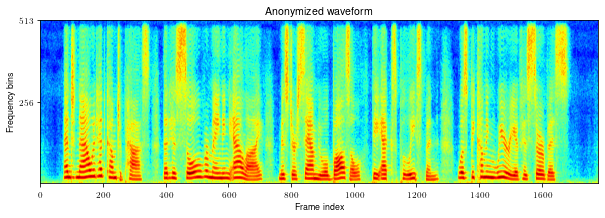

In [54]:
# Listen to the waveforms

import IPython.display
from tools import plot_API
from tools import plot_lib

IPython.display.display("Anonymized waveform")
IPython.display.display(IPython.display.Audio(anonymized_wav, rate=wav_sampling_rate))
plot_API.plot_API(anonymized_wav, plot_lib.plot_spec, 'single' ,
                  {'figsize': (10, 3), 'title': "Anonymized waveform"});


'Unprotected waveform'

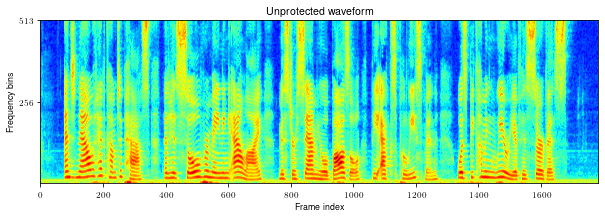

In [55]:
IPython.display.display("Unprotected waveform")
IPython.display.display(IPython.display.Audio(input_wav,  rate=wav_sampling_rate))
plot_API.plot_API(input_wav, plot_lib.plot_spec, 'single' ,
                  {'figsize': (10, 3), 'title': "Unprotected waveform"});

You can try with other samples and configurations.


# Section 2. DSP-based approach 

Here we briefly demonstrate the DSP-based approaches to change the perception of the speaker identity. 

Advantages:
1. DSP-based approaches usually don't require model training or data. (some DSP-based voice conversion techniques still need training such as clustering (Sundermann 2003, Srivastava 2020))
2. Randomness is understandable -- we know whether the randomness is (e.g., the alpha coefficient in baseline B2)
3. They may not require too much computation resources, at least, no GPU is required.

Disadvantages:
1. Many studies have questioned the effectiveness of DSP-based approaches for privacy protection. See latest summary in (Tomashenko 2022, Srivastava 2020).
2. Additional efforts may be needed to design the anonymization strategy: Baseline B2 simply uses a random number to control the anonymization. B2 of the previous challenge simply used a fixed number. None of them are sufficient to fulfill the requirement of the tasks set by the evaluation plan.
3. Most DSP-based approaches rely on a parametric speech waveform model, e.g., linear prediction. High-quality wavefrom can be resynthesized in copy-synthesis (i.e., unprotected) condition, but the quality degrades severely when some of the acoustic features are manipulated. It may fall behind good DNN-based approaches (see subjective evaluation VoicePrivacy2022)





## Sec.2.1 Baseline B2

This is directly copied from official implementation: 

https://github.com/Voice-Privacy-Challenge/Voice-Privacy-Challenge-2022/blob/master/baseline/local/anon/anonymise_dir_mcadams_rand_seed.py

The function is self-explainable. 

No training or additional resource is needed to anonymize one input waveform. However, we don't have a systematic way to anonymize the speaker vector -- there is no speaker vector, neither do we have a speaker pool.



<img src="https://d3i71xaburhd42.cloudfront.net/857ef52c30dddce03ecd2ffba2697b9dd2f9cb21/8-Figure1-1.png" alt="B2" width=450>


B2 is based on linear prediction. See (Patino 2021) for more details. 

For a tutorial on linear prediction, please check Resource section.



In [56]:
def anonym(freq, samples, winLengthinms=20, shiftLengthinms=10, lp_order=20, mcadams=0.8):
    """ output_wav = anonym(freq, samples, winLengthinms=20, shiftLengthinms=10, lp_order=20, mcadams=0.8)

    Anonymization using McAdam coefficient.

    :input: freq, int, sampling rate in Hz, 16000 in this case
    :input: samples, np.array, (L, 1) where L is the length of the waveform
    :input: winLengthinms, int, analysis window length (ms), default 20 ms
    :input: shiftLengthinms, int, window shift (ms), default 10 ms
    :input: lp_order, int, order of LP analysis, default 20
    :input: mcadams, float, alpha coefficients, default 0.8

    :output: output_wav, np.array, same shape as samples
    """
    
    eps = np.finfo(np.float32).eps
    samples = samples + eps
    
    # window length and shift (in sampling points)
    winlen = np.floor(winLengthinms * 0.001 * freq).astype(int)
    shift = np.floor(shiftLengthinms * 0.001 * freq).astype(int)
    length_sig = len(samples)
    
    # fft processing parameters
    NFFT = 2 ** (np.ceil((np.log2(winlen)))).astype(int)
    # anaysis and synth window which satisfies the constraint
    wPR = np.hanning(winlen)
    K = np.sum(wPR) / shift
    win = np.sqrt(wPR / K)
    # number of of complete frames  
    Nframes = 1 + np.floor((length_sig - winlen) / shift).astype(int) 
    
    # Buffer for output signal
    # this is used for overlap - add FFT processing
    sig_rec = np.zeros([length_sig]) 
    
    # For each frame
    for m in np.arange(1, Nframes):

        # indices of the mth frame
        index = np.arange(m * shift, np.minimum(m * shift + winlen, length_sig))    

        # windowed mth frame (other than rectangular window)
        frame = samples[index] * win 

        # get lpc coefficients
        a_lpc = librosa.core.lpc(frame + eps, lp_order)

        # get poles
        poles = scipy.signal.tf2zpk(np.array([1]), a_lpc)[1]

        #index of imaginary poles
        ind_imag = np.where(np.isreal(poles) == False)[0]

        #index of first imaginary poles
        ind_imag_con = ind_imag[np.arange(0, np.size(ind_imag), 2)]
        
        # here we define the new angles of the poles, shifted accordingly to the mcadams coefficient
        # values >1 expand the spectrum, while values <1 constract it for angles>1
        # values >1 constract the spectrum, while values <1 expand it for angles<1
        # the choice of this value is strongly linked to the number of lpc coefficients
        # a bigger lpc coefficients number constraints the effect of the coefficient to very small variations
        # a smaller lpc coefficients number allows for a bigger flexibility
        new_angles = np.angle(poles[ind_imag_con]) ** mcadams
        #new_angles = np.angle(poles[ind_imag_con])**path[m]
        
        # make sure new angles stay between 0 and pi
        new_angles[np.where(new_angles >= np.pi)] = np.pi
        new_angles[np.where(new_angles <= 0)] = 0  
        
        # copy of the original poles to be adjusted with the new angles
        new_poles = poles
        for k in np.arange(np.size(ind_imag_con)):
            # compute new poles with the same magnitued and new angles
            new_poles[ind_imag_con[k]] = np.abs(poles[ind_imag_con[k]]) * np.exp(1j * new_angles[k])
            # applied also to the conjugate pole
            new_poles[ind_imag_con[k] + 1] = np.abs(poles[ind_imag_con[k] + 1]) * np.exp(-1j * new_angles[k])            
        
        # recover new, modified lpc coefficients
        a_lpc_new = np.real(np.poly(new_poles))

        # get residual excitation for reconstruction
        res = scipy.signal.lfilter(a_lpc,np.array(1),frame)

        # reconstruct frames with new lpc coefficient
        frame_rec = scipy.signal.lfilter(np.array([1]),a_lpc_new,res)
        frame_rec = frame_rec * win    
        outindex = np.arange(m * shift, m * shift + len(frame_rec))

        # overlap add
        sig_rec[outindex] = sig_rec[outindex] + frame_rec

    sig_rec = (sig_rec / np.max(np.abs(sig_rec)) * (np.iinfo(np.int16).max - 1)).astype(np.int16)
    return sig_rec

In [57]:
# Please specify the trial name here
trial_name = '3536-8226-0001'

# prepare file paths
input_data_dir = './data/input_trial'
input_wav_f = os.path.join(input_data_dir, trial_name) + '.wav'

# load input waveform
sr, input_wav = waveReadAsFloat(input_wav_f)

In [58]:
random_coef = and_mc_coeff = random.uniform(0.5, 0.9)
print("Coefficient \alpha = ", random_coef)
anonymized = anonym(sr, input_wav, winLengthinms=20, shiftLengthinms=10, lp_order=20, 
                    mcadams=random_coef)


Coefficient lpha =  0.6807878349717043


'Anonymized waveform'

'Unprotected waveform'

(<Figure size 720x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Unprotected waveform'}, xlabel='Frame index', ylabel='Frequency bins'>)

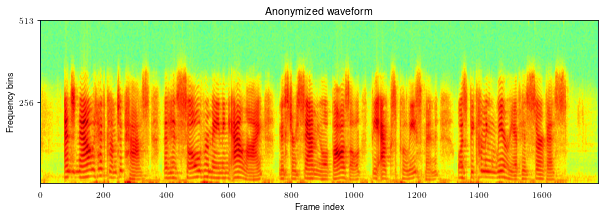

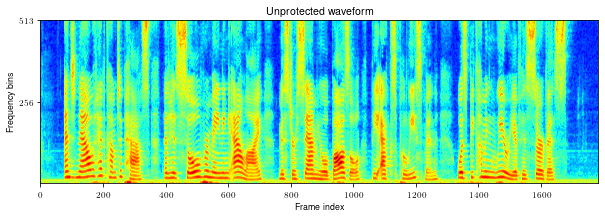

In [59]:
# Listen to the waveforms

import IPython.display
from tools import plot_API
from tools import plot_lib

IPython.display.display("Anonymized waveform")
IPython.display.display(IPython.display.Audio(anonymized, rate=wav_sampling_rate))
plot_API.plot_API(anonymized, plot_lib.plot_spec, 'single' ,
                  {'figsize': (10, 3), 'title': "Anonymized waveform"})


IPython.display.display("Unprotected waveform")
IPython.display.display(IPython.display.Audio(input_wav,  rate=wav_sampling_rate))
plot_API.plot_API(input_wav, plot_lib.plot_spec, 'single' ,
                  {'figsize': (10, 3), 'title': "Unprotected waveform"})

Note that the spectra of anonymized speech are quite different from the original one -- energy distribution, spectral tilt, ...


## Sec.2.2 Alternative approach

**Vocal tract length pertubation**

The paper on Baseline B2 (Patino 2021) mentions vocal tract length pertubation in related work. This is a technique widely used in data augmentation and classic voice conversion technique. 


To keep the pitch unchanged, we can extract the spectral envelope and change it. Then, we resynthesis the waveform. Depending on the speech vocoder, we may also get aperiodicity and we can change them too.

```     
                             |-> F0             -----------------> | 
                             |                                     |
Input wav -->   Analyze   --|-> Spectral env.  ---> Freq. warp -> | -> Synthesize -> output wav
                             |                                     |
                             |-> Aperiodicity   -----------------> |
```



**Installation**

Let's try to use WORLD vocoder (Morise 2016) to analyze and synthesize the waveform

In [60]:
# install pyworld https://pypi.org/project/pyworld/
!pip install pyworld

**Define warping function**

Vocal tract length pertubation needs a frequency warping function $f$ that maps an input frequency value $x$ into a new frequency value $y$. 

Many choices are available (see (Pitz 2007)), but here we use a bilinear function (Tokuda 1994). It is the phase response of an all-pass filter:

$H_\alpha(z) = \frac{z^{-1}-\alpha}{1-\alpha z^{-1}} |_{z = e^{jw}} = e^{-j\beta_\alpha(w)}$, where
$w' = \beta_\alpha(w) = \tan^{-1}\frac{(1-\alpha^2) \sin w}{(1+\alpha^2)\cos w - 2\alpha}$

$\beta_\alpha(w)$ is the warping function we need. 

Notice that if $w' = \beta_{\alpha}(w)$, $w = \beta_{-\alpha}(w')$.



In [61]:
def warp_function_bilinear(normed_freq, alpha=0):
    """ warped_freq = warp_function_quadratic(normed_freq)
    :input: normed_freq, float, normalized frequency between (1, np.pi)
    :input: alpha, float, a coefficient for warping
    :output: warped_freq, float, warped normalized frequency value
    """
    if np.any(normed_freq < 0) or np.any(normed_freq > np.pi):
        print("Input freq. out of range")
        sys.exit(1)
    nom = (1 - alpha * alpha) * np.sin(normed_freq)
    den = (1 + alpha * alpha) * np.cos(normed_freq) - 2 * alpha
    output = np.arctan(nom / den)
    output[output < 0] = output[output < 0] + np.pi
    return output


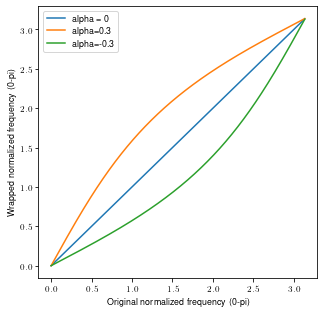

In [62]:
# plot figure
orig_rad = np.arange(0, 512)/512 * np.pi
warp_rad1 = warp_function_bilinear(orig_rad, alpha=0.0)
warp_rad2 = warp_function_bilinear(orig_rad, alpha=0.3)
warp_rad3 = warp_function_bilinear(orig_rad, alpha=-0.3)

fig = plt.figure(figsize=(5, 5))
axis = fig.add_subplot(111)
axis.plot(orig_rad, warp_rad1)
axis.plot(orig_rad, warp_rad2)
axis.plot(orig_rad, warp_rad3)
axis.set_xlabel('Original normalized frequency (0-pi)')
axis.set_ylabel('Wrapped normalized frequency (0-pi)')
axis.legend(['alpha = 0', 'alpha=0.3', 'alpha=-0.3'])

**interpolation**


Ideally, given an input spectrum $s(w)$, we can get the warped spectrum by $s_\alpha(w') = s(\beta_{-\alpha}(w'))$. However, our spectrum $s[n]$ by discrete Fourier transform is measured on a set of discrete frequency bins $n\in[1, \text{FFT_bins}//2+1)$. $\beta_{-\alpha}(w')$ may not correspond to any $n$.

Thus, we need to interpolate between the nearest frequency bins.



```
-- s'[0] --- s'[1] --- s'[2] --- s'[3] --- s'[4] --- ...
      |         |         |         |         |
w':  2pi/N*0  2pi/N*1  2pi/N*2  2pi/N*3  2pi/N*4 ...
      |         |        /         /       /         /
      |        /       /         /       /        /     \beta_{-\alpha}
      |       /       /        /       /       /
      |      |      |        |        |      |
--- s[0] --- s[1] --- s[2] ---- s[3] --- s[4] --- ...
```

For example, `s'[1]` is interpolated from s[0] and [1]. 

How to interpolate the value requires quite a lot expertice. Here, we just do a simple weighted sum.


In [63]:
def warp_interpolation(spec, warp_func, alpha):
    """output = wrap_interpolation(rad, spec)
    input
    -----
      spec: spectra evelope, (L, N), where L is the frame number
      warp_func: a warp function
      
    output
    ------
      output: spectra evelope, (L, N), where L is the frame number
    """
    nbins = spec.shape[1]
    
    # uniform sampling on warpped frequency scale w' 
    warp_rad = np.arange(0, nbins) / nbins * np.pi

    # the corresponding frequency on original scale
    # w = \beta_{-\alpha}(w')
    orig_rad = warp_func(warp_rad, alpha=alpha * -1)

    # 
    if np.mean(np.abs(warp_rad - orig_rad)) < 0.0001:
        # if the warping is too trival, don't do interpolation
        return spec
    else:
        output = np.zeros_like(spec)

        # naive implementation of interpolation
        for rad_idx in np.arange(nbins):
            # normalized frequency value on the original frequency bin
            orig = orig_rad[rad_idx]
            # which bin? i.e., the value of k in 2pi/N * k
            orig_idx = orig / np.pi * nbins
            # find the closest discrete bin index
            idx_left = int(np.floor(orig_idx))
            idx_right = int(np.ceil(orig_idx))

            # boundary condition
            if idx_left < 0:
                idx_left = 0
            if idx_right >= nbins:
                idx_right = nbins - 1

            if idx_left == idx_right:
                # if warped frequency bin happens to be mapped to an integer
                w_l, w_r = 0.0, 1.0
            else:
                # otherwise, compute distance between warped and discrete bin
                # as weight
                w_l = orig_idx - idx_left
                w_r = idx_right - orig_idx

            # weighted sum
            output[:, rad_idx] = spec[:, idx_left] * w_l + spec[:, idx_right] * w_r
        return output

**Anonymize waveform**



In [64]:
# Please specify the trial name here
# you can choose other waveforms in ./data/input_trial
trial_name = '3536-8226-0001'

# prepare file paths
input_data_dir = g_workpath + '/data/input_trial'
input_wav_f = os.path.join(input_data_dir, trial_name) + '.wav'

# load input waveform
sr, input_wav = waveReadAsFloat(input_wav_f)

In [65]:

import pyworld as pw

#===
# analysis
#===
x = np.array(input_wav, dtype=np.float64)
_f0, t = pw.dio(x, sr)    # raw pitch extractor
f0 = pw.stonemask(x, _f0, t, sr)  # pitch refinement
sp = pw.cheaptrick(x, f0, t, sr)  # extract smoothed spectrogram
ap = pw.d4c(x, f0, t, sr)         # extract aperiodicity

# synthesis the original waveform
# y = pw.synthesize(f0, sp, ap, sr) # synthesize an utterance using the parameters

#===
# Warping
#===
alpha = 0.3

# warp spectral envlope and aperiodicity
sp_warpped = warp_interpolation(sp, warp_function_bilinear, alpha)
ap_warpped = warp_interpolation(ap, warp_function_bilinear, alpha)

#===
# synthesis
#===
y_wrapped = pw.synthesize(f0, sp_warpped, ap_warpped, sr) # synthesize an utterance using the parameters

'Anonymized waveform'

'Unprotected waveform'

(<Figure size 720x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Unprotected waveform'}, xlabel='Frame index', ylabel='Frequency bins'>)

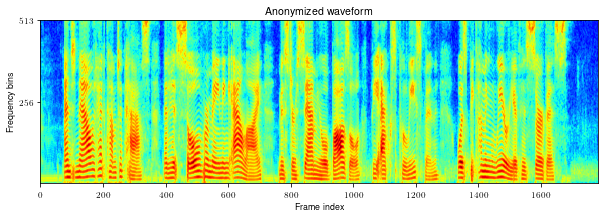

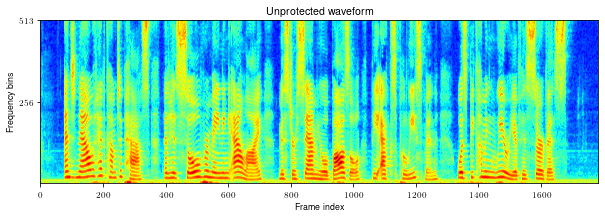

In [66]:
# Listen to the waveforms

import IPython.display
from tools import plot_API
from tools import plot_lib

IPython.display.display("Anonymized waveform")
IPython.display.display(IPython.display.Audio(y_wrapped, rate=sr))
plot_API.plot_API(y_wrapped, plot_lib.plot_spec, 'single' ,
                  {'figsize': (10, 3), 'title': "Anonymized waveform"})


IPython.display.display("Unprotected waveform")
IPython.display.display(IPython.display.Audio(input_wav,  rate=sr))
plot_API.plot_API(input_wav, plot_lib.plot_spec, 'single' ,
                  {'figsize': (10, 3), 'title': "Unprotected waveform"})

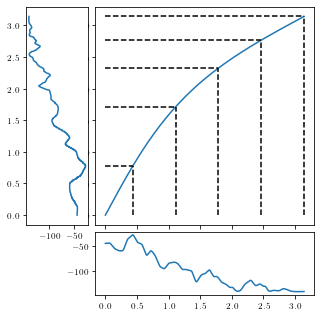

In [67]:
# Let's check one frame

# which frame to plot
frame_idx = 300

fft_bins = (sp_warpped.shape[1] - 1) * 2
orig_rad = np.arange(0, (fft_bins // 2)+1) / fft_bins * 2 * np.pi
warp_rad = warp_function_bilinear(orig_rad, alpha=alpha)


# which frequency value to plot? we can choose freely
# Let's find 5 bins between the maximum spectrum point and Nyquist freq. 
idx = np.argsort(sp[frame_idx])
rads_plot = np.linspace(orig_rad[idx][-1], np.pi, 5)


def logspec(spec):
    return 20 * np.log10(spec + 1e-7)

#===
# plot figure
#===

fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, 2,  width_ratios=(2, 7), height_ratios=(7, 2),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[0, 1])
ax_histx = fig.add_subplot(gs[0, 0], sharey=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharex=ax)

ax.plot(orig_rad, warp_rad)
ax_histy.plot(orig_rad, logspec(sp[frame_idx]))
#ax_histy.set_xticks([])
#ax_histy.set_yticks([])
ax_histx.plot(logspec(sp_warpped[frame_idx]), orig_rad)
#ax_histx.invert_xaxis()
#ax_histx.set_xticks([])
#ax_histx.set_yticks([])

for rad in rads_plot:
    warp_rad = warp_function_bilinear(np.expand_dims(rad, axis=0), alpha)[0]
    ax.plot([rad, rad], [0, warp_rad], color='k', linestyle='--')
    ax.plot([0, rad], [warp_rad, warp_rad], color='k', linestyle='--')


VTLP was used for voice annoymization in (Srivastava 2020). Its effectiveness is questionable.

We can design a more complicated way to choose $\alpha$ so that all the requirements in the evaluation plan can be satisfied. 

You can check more in the above paper to find whether these DSP-based techniques are strong enough to conceal speaker identity.

# Remarks on baselines

* DNN-based ones: 
   
  * Performance is good when facing lazy-informed attacker.

  * Performance is **poor** when facing stronger attacker (see next talk).
   
  * It is too complicated.

* DSP-based ones: 

  * It is easy to run

  * Anonymization performance is limited
  
  * There is no good representation for speaker identity
  
  
  


**Challenge Participants have better solutions**

See more in the VoicePrivacy challenge summary talk and participants' presentations.

# Reference & resources



## Refenence list

VoicePrivacy 2020 Findings and summary
```
Natalia Tomashenko, Xin Wang, Emmanuel Vincent, Jose Patino, Brij Mohan Lal Srivastava, Paul-Gauthier Noé, Andreas Nautsch, Nicholas Evans, Junichi Yamagishi, Benjamin O’Brien, Anaïs Chanclu, Jean-François Bonastre, Massimiliano Todisco, and Mohamed Maouche. The VoicePrivacy 2020 Challenge: Results and Findings. Computer Speech & Language, February, 101362. doi:https://doi.org/10.1016/j.csl.2022.101362. 2022.
```

VoicePrivacy 2022 [evaluation plan](https://www.voiceprivacychallenge.org/docs/VoicePrivacy_2022_Eval_Plan_v1.0.pdf)
```
Natalia Tomashenko, Xin Wang, Xiaoxiao Miao, Hubert Nourtel, Pierre Champion, Massimiliano Todisco, Emmanuel Vincent, Nicholas Evans, Junichi Yamagishi, and Jean François Bonastre. The VoicePrivacy 2022 Challenge Evaluation Plan. ArXiv Preprint ArXiv:2203.12468. 2022.
```

Baseline B2
```
Jose Patino, Natalia Tomashenko, Massimiliano Todisco, Andreas Nautsch, and Nicholas Evans. Speaker Anonymisation Using the McAdams Coefficient. In Proc. Interspeech, 1099–1103. doi:10.21437/Interspeech.2021-1070. 2021.
```

Alternative systems using SSL models
```
Xiaoxiao Miao, Xin Wang, Erica Cooper, Junichi Yamagishi, and Natalia Tomashenko. Language-Independent Speaker Anonymization Approach Using Self-Supervised Pre-Trained Models. In The Speaker and Language Recognition Workshop (Odyssey 2022), 279–286. ISCA: ISCA. doi:10.21437/Odyssey.2022-39. 2022.
```



For full baseline anonymization systems, please check the official Github repository 

[![On Github](https://badgen.net/badge/icon/github?icon=github&label)](https://github.com/Voice-Privacy-Challenge/Voice-Privacy-Challenge-2022)


## DNN-based methods


### Neural waveform models

For more details on the neural vocoder in B1.b, please check this ICASSP 2022 short course (please check chapter 9):

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1EO-ggi1U9f2zXwTiqg7AEljVx11JKta7#scrollTo=EAJ_-GCO3YU0)

For other neural vocoders, check all the notebooks linked here:

https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/master/tutorials/b1_neural_vocoder/README.md





### Pure Python/Pytorch-based full-fledged model

You may check this [open-sourced repo](https://github.com/nii-yamagishilab/SSL-SAS)

```python
@article{miao2022language,
address = {ISCA},
author = {Miao, Xiaoxiao and Wang, Xin and Cooper, Erica and Yamagishi, Junichi and Tomashenko, Natalia},
doi = {10.21437/Odyssey.2022-39},
journal = {The Speaker and Language Recognition Workshop (Odyssey 2022)},
pages = {279--286},
title = {{Language-Independent Speaker Anonymization Approach Using Self-Supervised Pre-Trained Models}},
url = {https://www.isca-speech.org/archive/odyssey_2022/miao22_odyssey.html},
year = {2022}
}
```


## DSP-based methods


Some other tutorials on DSP techqniues:
1. Course on speech signal processing from Dr. Tom Bäckström and colleagues: [link](https://speechprocessingbook.aalto.fi/)
```sh
@book{itsp2022,
   title = {Introduction to Speech Processing},
   edition = 2,
   year = 2022,
   author = {Tom Bäckström and Okko Räsänen and Abraham Zewoudie and Pablo Pérez Zarazaga and Liisa Koivusalo and Sneha Das and Esteban Gómez Mellado and Marieum Bouafif Mansali and Daniel Ramos},
   url = {https://speechprocessingbook.aalto.fi},
   doi = {10.5281/zenodo.6821775},
   }
```
2. Basic DSP techniques (frameing, overlap-add): Chapter 2 of the ICASSP 2022 short course: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1mZo73dbKeWr4hDHftDQI9rlDK1HyMf5C?usp=sharing) 
3. Linear prediction: Chapter a1 of the ICASSP 2022 short course: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1g-_rveOLSdqFtnl2IrLyHOUyW01-gN6y?usp=sharing) 

## More methods from participants

VoicePrivacy Challenge 2020:
https://www.voiceprivacychallenge.org/vp2020/#systems

VoicePrivacy Challenge 2022 (to be added):
https://www.voiceprivacychallenge.org/



# ACKNOWLEDGEMENT

VoicePrivacy is supported in part by the French National Research Agency under the DEEP-PRIVACY project (ANR-18-CE23-0018), by the European Union’s Horizon 2020 Research and Innovation Program under Grant Agreement No. 825081 COMPRISE, and jointly by the French National Research Agency and the Japan Science and Technology Agency under the VoicePersonae project. This work is also supported by MEXT KAKENHI Grants (21K17775, 21H04906).

<img src="https://www.voiceprivacychallenge.org/img/anr.jpg" alt="My Image" width=90>

<img src="https://www.voiceprivacychallenge.org/img/comprise.png" alt="My Image" width=500>


<img src="https://www.voiceprivacychallenge.org/img/ec2.png" alt="My Image" width=150>

<img src="https://www.voiceprivacychallenge.org/img/jst.png" alt="My Image" width=300>


For more information, please check https://www.voiceprivacychallenge.org/


